In [1]:
from Utils.preprocessing import *
from Utils.pipelineComponents import *
from Utils.preprocessing import *

import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

RANDOM_STATE = 2024

# Webscraping Portion

In [2]:
# Read prof's sample data to view format & data science roles
sample_data_a = pd.read_csv("Data/jobs_in_data.csv")
sample_data_b = pd.read_csv("Data/QF632_Project_2_b.csv")
sample_data_c = pd.read_csv("Data/QF632_Project_2_c.csv")
sample_data_d = pd.read_csv("Data/Glassdoor_Salary_Cleaned_Version.csv")

In [3]:
base_url = "https://h1bdata.info/index.php?em=&job=data+scientist&city=&year=all+years"
roles = ["data scientist", "data analyst", "data storyteller", "data insights", "research scientist", "business data analyst",
        "data analytics", "data engineer", "machine learning", "ml engineer", "ai architect"]

all_df = pd.DataFrame()
for role in roles:
    job = "+".join(role.split(" "))
    url = base_url + "/index.php?em=&job=" + job + "&city=&year=all+years"
    try: 
        dfs_base = pd.read_html(url)
    except: 
        continue
    
    # to include all other variations, add a '&'
    url = base_url + "/index.php?em=&job=" + job + "+&&city=&year=all+years"
    
    try:
        dfs_var = pd.read_html(url)
    except:
        continue
    
    temp_df = pd.concat([dfs_base[0], dfs_var[0]])
    temp_df["TYPE"] = role
    
    all_df = pd.concat([all_df, temp_df])

print(all_df.shape)
all_df.sample(5)

(80921, 8)


,EMPLOYER,JOB TITLE,BASE SALARY,LOCATION,SUBMIT DATE,START DATE,Unnamed: 6,TYPE
11289,F45 TRAINING INC,DATA ANALYST,110000,"AUSTIN, TX",11/16/2021,11/29/2021,NaN,data analyst
11203,THE BOSTON CONSULTING GROUP INC,DATA SCIENTIST,120000,"BOSTON, MA",03/29/2020,09/15/2020,NaN,data scientist
1492,AMAZON WEB SERVICES INC,DATA ENGINEER I,111440,"ASHBURN, VA",10/05/2022,10/10/2022,NaN,data engineer
459,GV20 THERAPEUTICS LLC,MACHINE LEARNING ENGINEER,86000,"WALTHAM, MA",05/28/2021,10/01/2021,NaN,machine learning
7010,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,RESEARCH SCIENTIST,130000,"CAMBRIDGE, MA",06/20/2019,09/01/2019,NaN,research scientist


# Data Analysis

In [4]:
all_df["START DATE"] = pd.to_datetime(all_df["START DATE"], errors='coerce')
all_df["SUBMIT DATE"] = pd.to_datetime(all_df["SUBMIT DATE"], errors='coerce')
all_df = all_df.drop_duplicates()

# Remove all non-numeric "y" values
all_df2 = all_df[pd.to_numeric(all_df['BASE SALARY'], errors='coerce').notnull()].copy()

# all_df2 = all_df.dropna(subset = ["BASE SALARY"]).copy()
all_df2 = all_df2.drop(columns=["Unnamed: 6"]).reset_index(drop=True)
all_df2["YEAR"] = pd.DatetimeIndex(all_df2['START DATE']).year

# To get state, first remove all symbols, then take the last two letters
regex = re.compile('[^a-zA-Z]')
all_df2['STATE'] = all_df2.LOCATION.apply(lambda x:regex.sub('', x)[-2:])
all_df2 = all_df2.rename(columns={"BASE SALARY":"y"})
all_df2["y"] =  pd.to_numeric(all_df2["y"]) / 1000

print(all_df2.shape)
all_df2.sample(5)

(74810, 9)


,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE
25953,ASPYRETECH INC,DATA ANALYST,65.000,"DUNWOODY, GA",2017-03-07,2017-09-01,data analyst,2017,GA
52545,PLAYSTUDIOS US LLC,DATA ENGINEER,116.160,"LAS VEGAS, NV",2022-09-21,2022-10-15,data engineer,2022,NV
36388,MOTORISTS MUTUAL INSURANCE COMPANY,DATA ANALYST II,88.305,"COLUMBUS, OH",2015-11-03,2016-03-11,data analyst,2016,OH
46642,THE HENRY M JACKSON FOUNDATION,RESEARCH SCIENTIST,900.000,"BETHESDA, MD",2017-10-26,2017-11-27,research scientist,2017,MD
66135,AMAZONCOM SERVICES LLC,DATA ENGINEER I,121.295,"SEATTLE, WA",2020-08-03,2020-08-05,data engineer,2020,WA


## 1. Numerical Features

## 2. Categorical features
- Not sure if there is a way to further categorize the data into bigger subgroups (i.e., segregating state to urban and rural areas)

### 2a. Analysis of job demand by job function

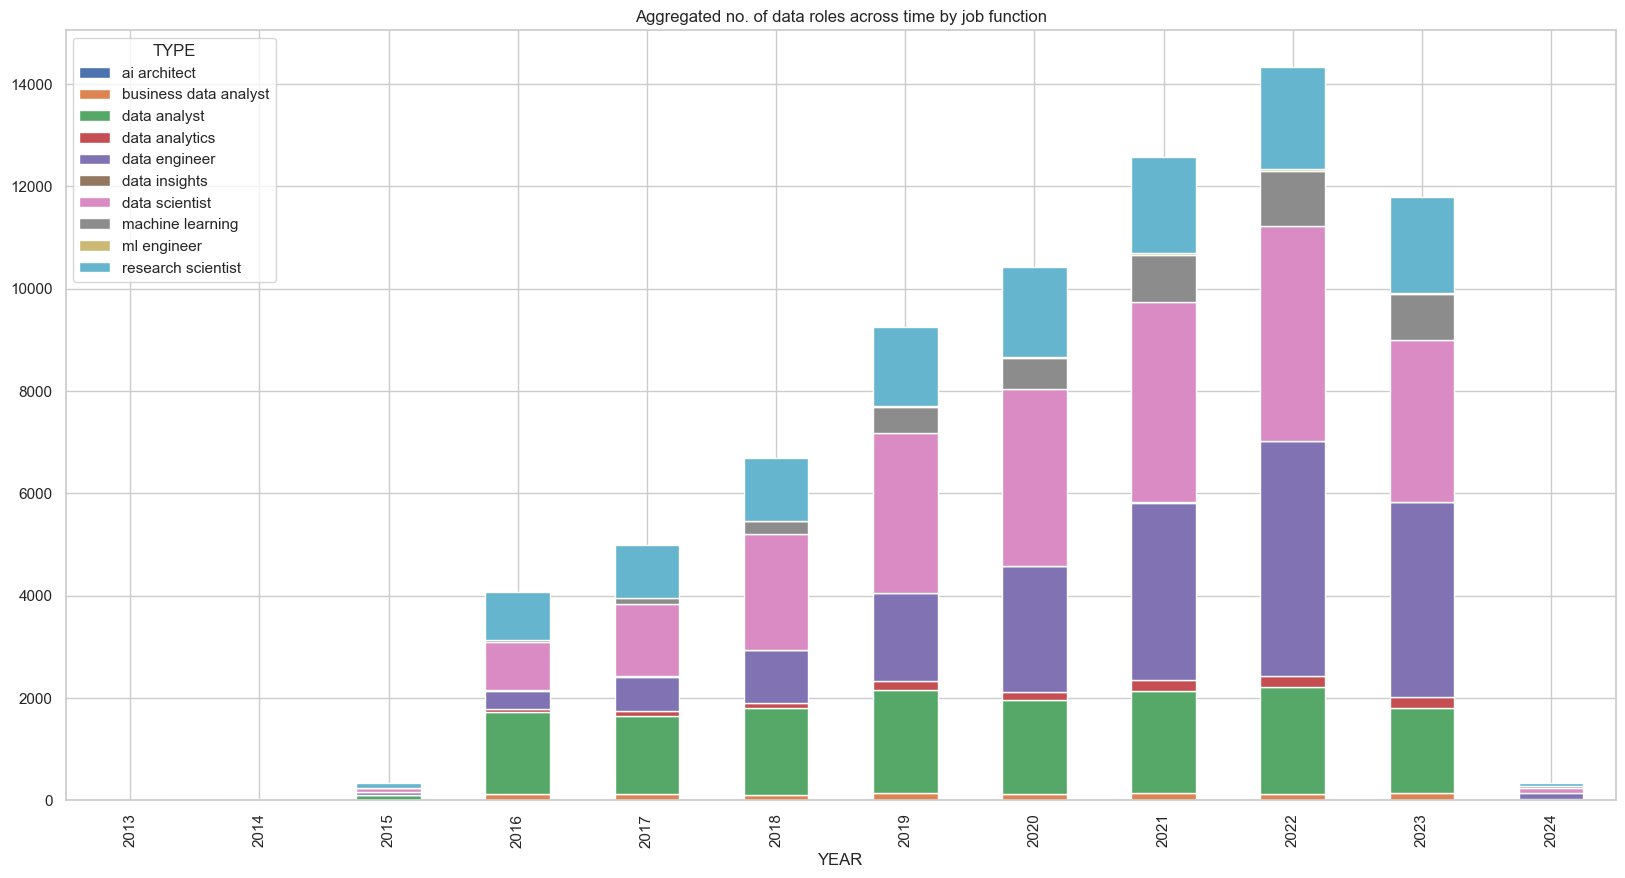

In [134]:
category = "TYPE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="Aggregated no. of data roles across time by job function")

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/2251632435.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_type_agg['TYPE'].mask(~df_type_agg["TYPE"].isin(core_cat) ,'others', inplace=True)


TYPE
data scientist        22637
data engineer         18283
data analyst          14573
research scientist    12404
others                 6913
Name: count, dtype: int64


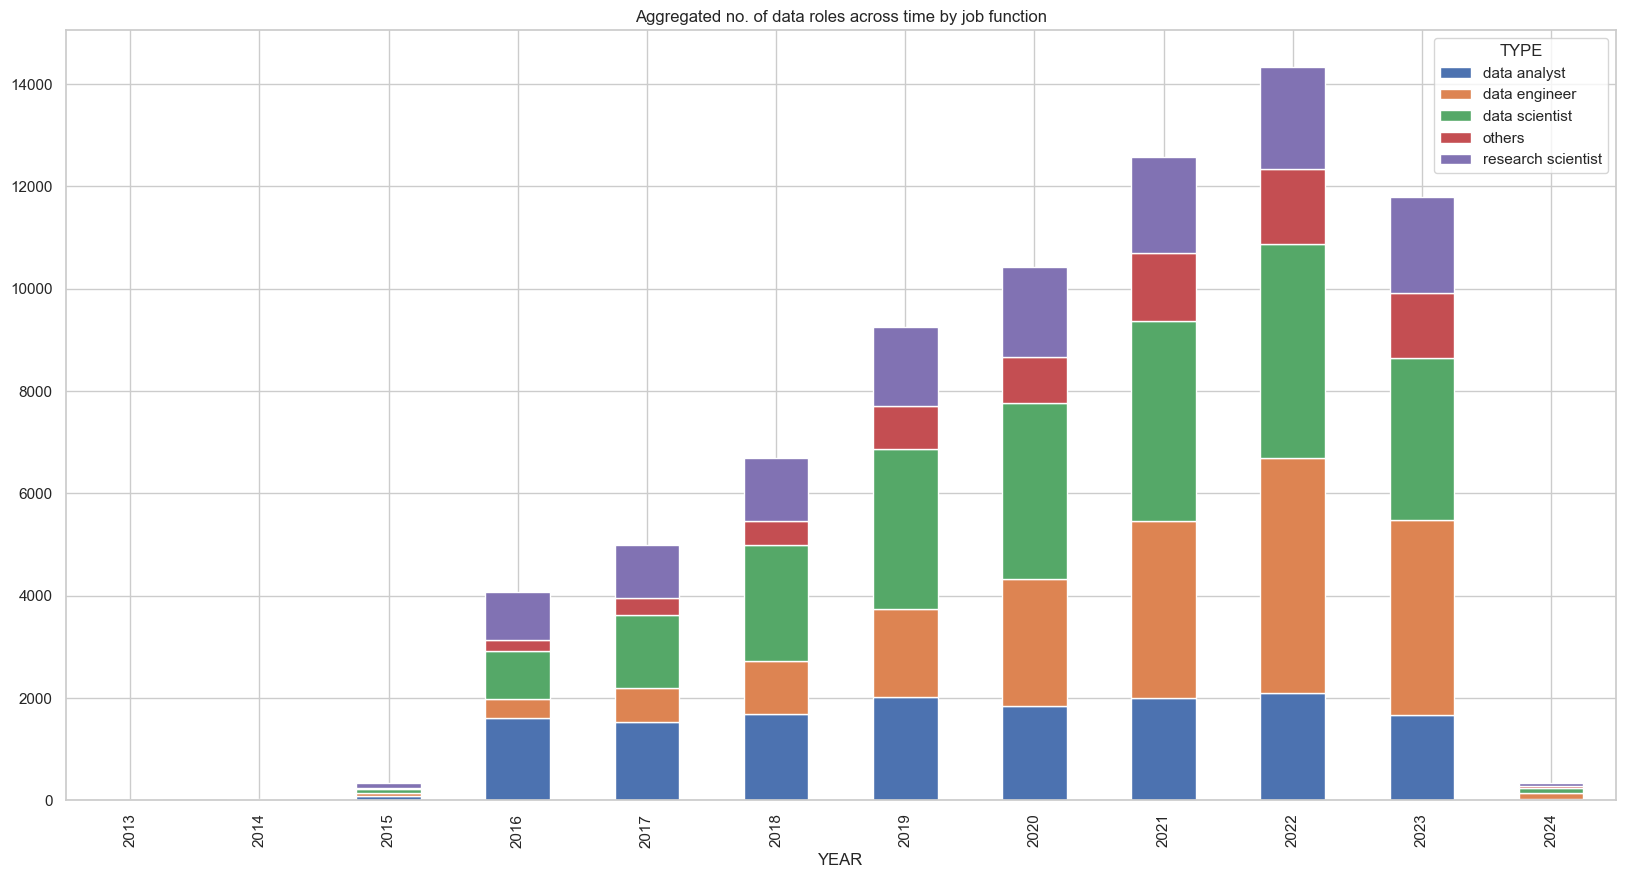

In [135]:
df_type_agg = all_df2.copy()
core_cat = ["research scientist", "data scientist", "data analyst", "data engineer"]
df_type_agg['TYPE'].mask(~df_type_agg["TYPE"].isin(core_cat) ,'others', inplace=True)

df_plt = df_type_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_type_agg["TYPE"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), stacked=True, title="Aggregated no. of data roles across time by job function")

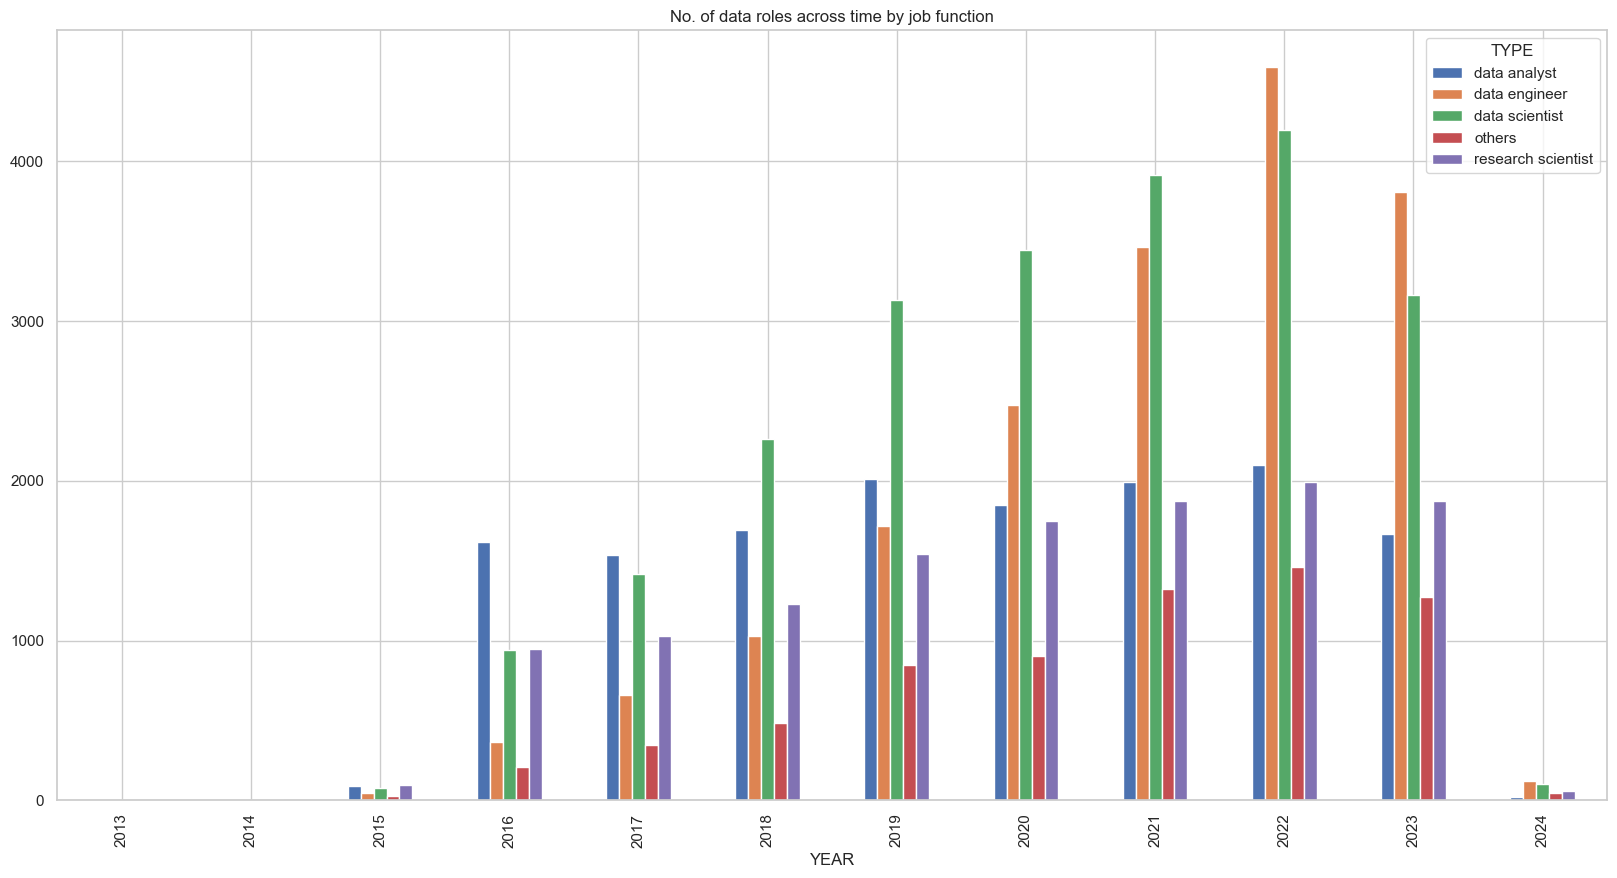

In [136]:
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by job function")

Job functions not of major classes (data analyst, data engineer, data scientist, research scientist) can form 1 class called "others".
From the graphs above, we can see that the number of data roles have been increasing across time, peaking in 2022. Further breakdown of the data roles into the major classes shows that demand for data engineers have seen the most growth across time, and remains to be of the highest demand today. Data scientists and research scientists have also seen a general increase in demand, while data analysts have seen fluctuations in demand across years.

### 2b. Analysis of wage by job function

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/3940554362.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plt = df_type_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])


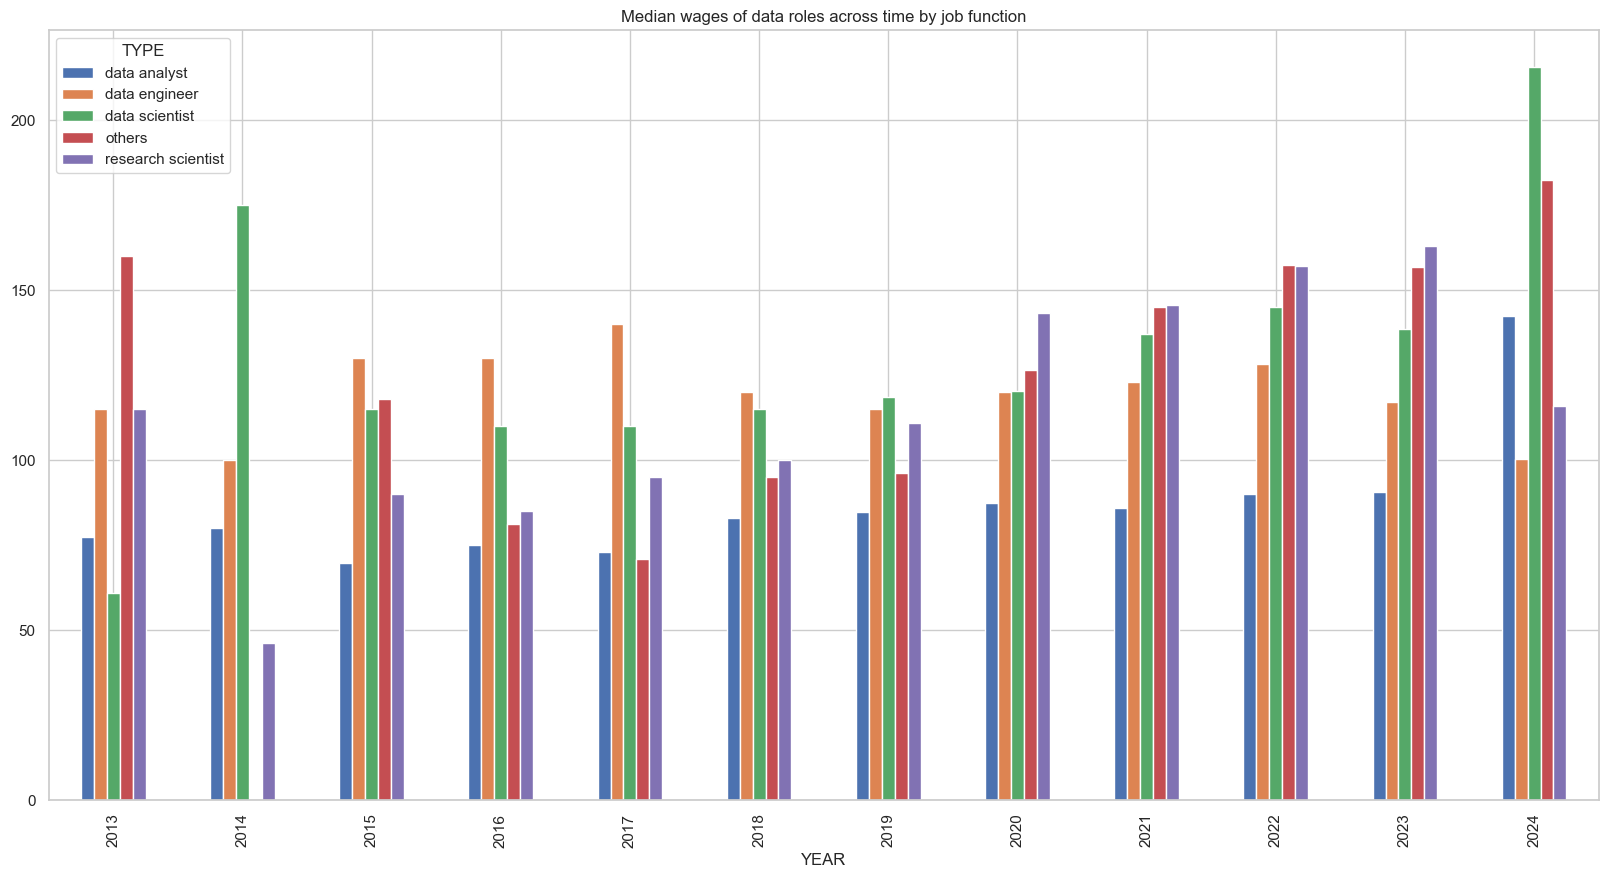

In [137]:
# get median wage of each job role for each year
df_plt = df_type_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by job function")

Generally, the median wages of all job functions have increased over time. As of 2024, data scientists have the highest median wage, followed by other functions, then data analysts, research scientists and data engineers. Compared to all other job functions, data scientists and data analysts have seen the largest increase in median wages from 2023 to 2024.

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/2379994539.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,


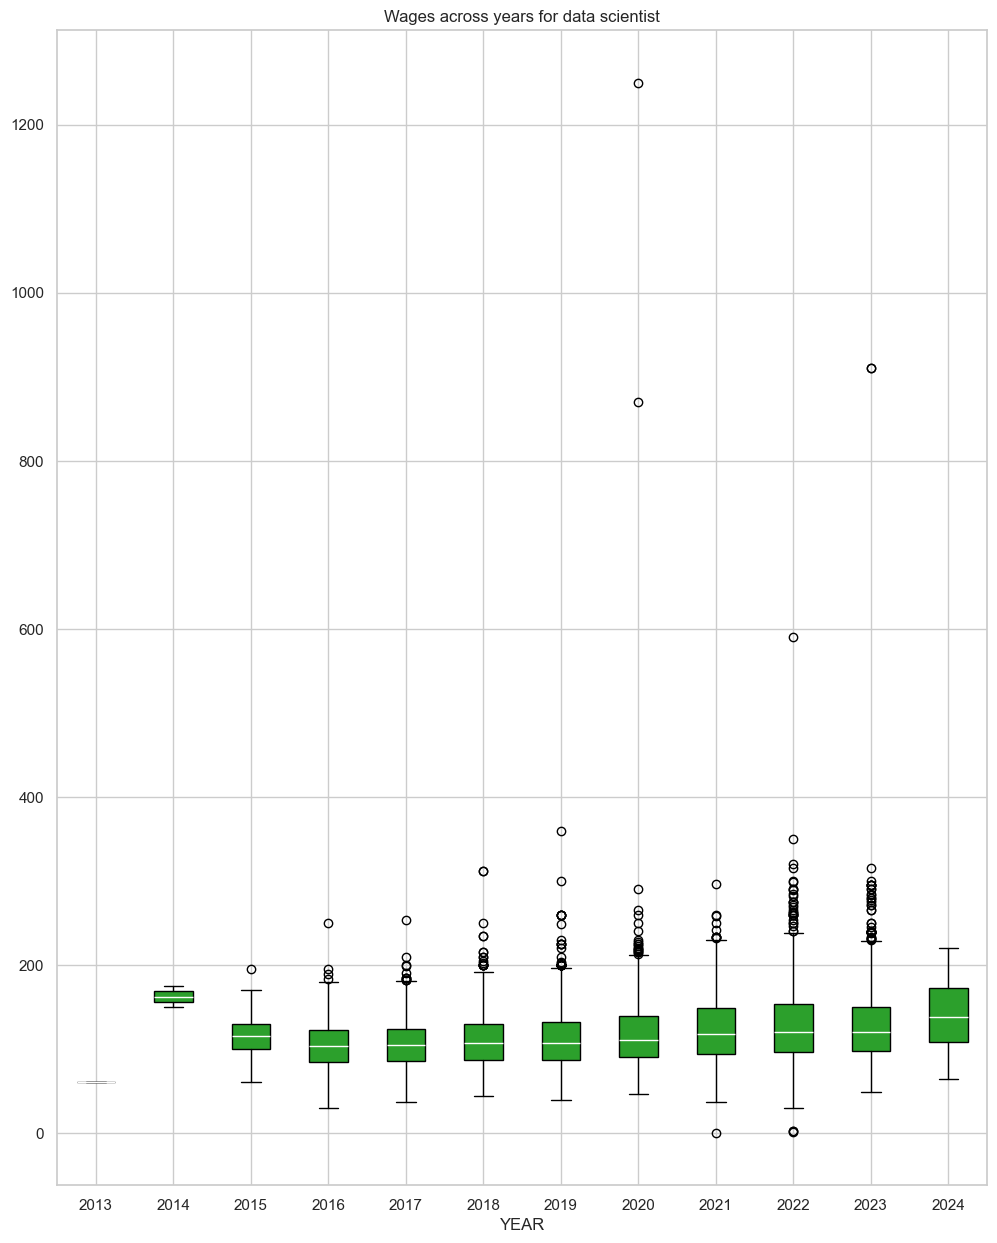

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/2379994539.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,


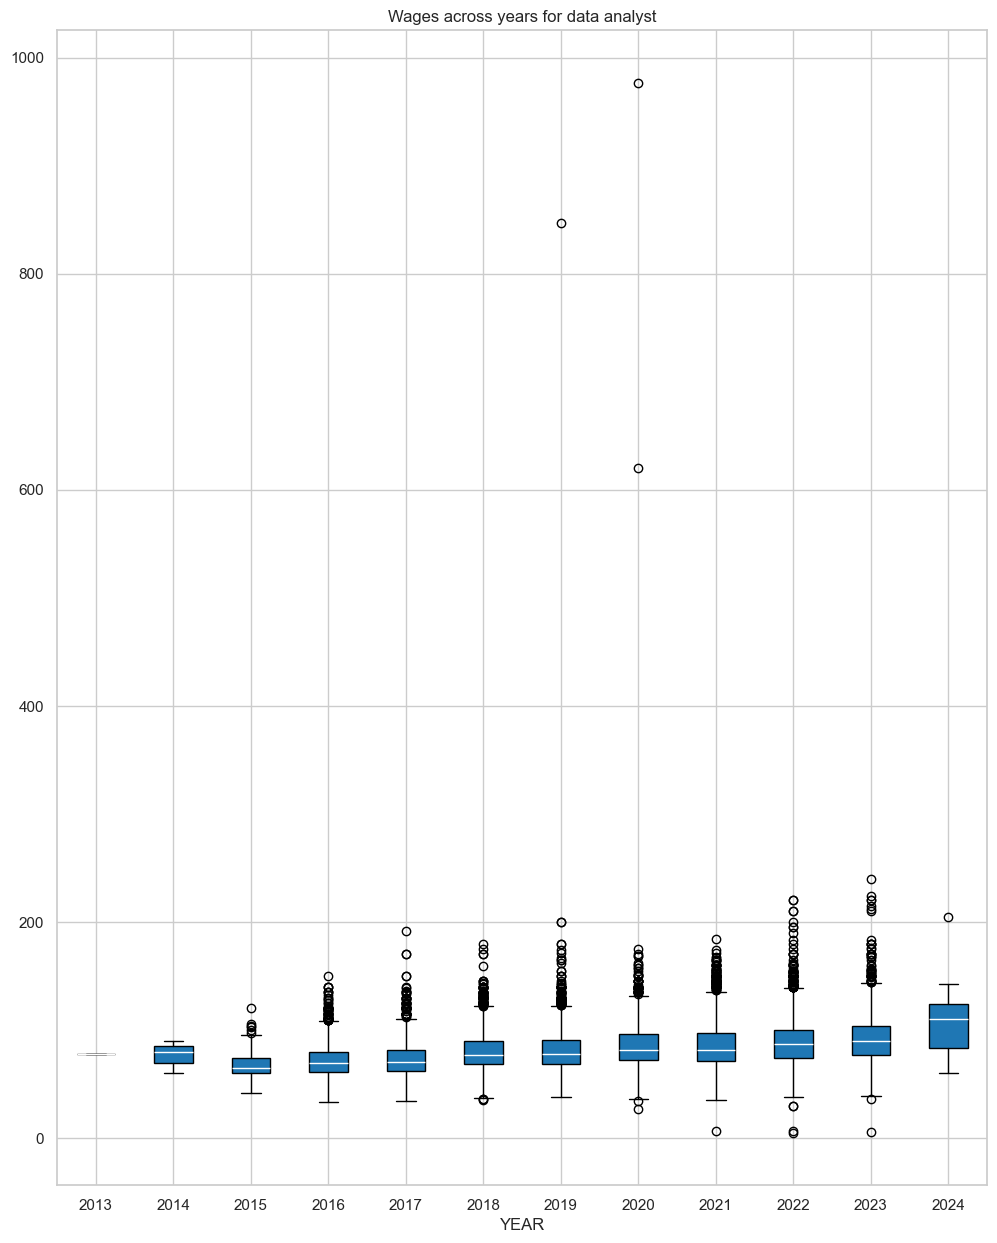

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/2379994539.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,


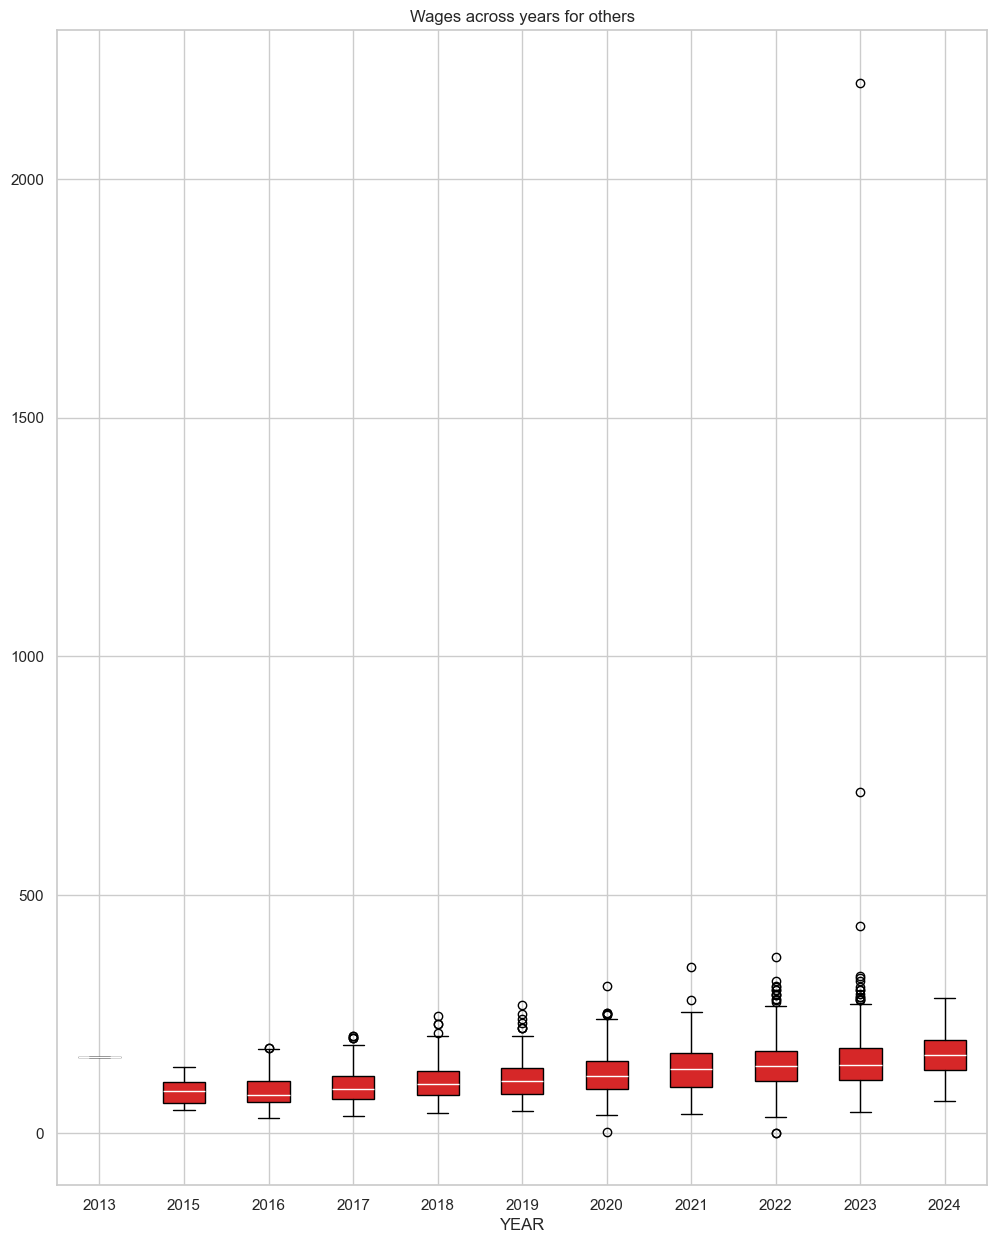

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/2379994539.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,


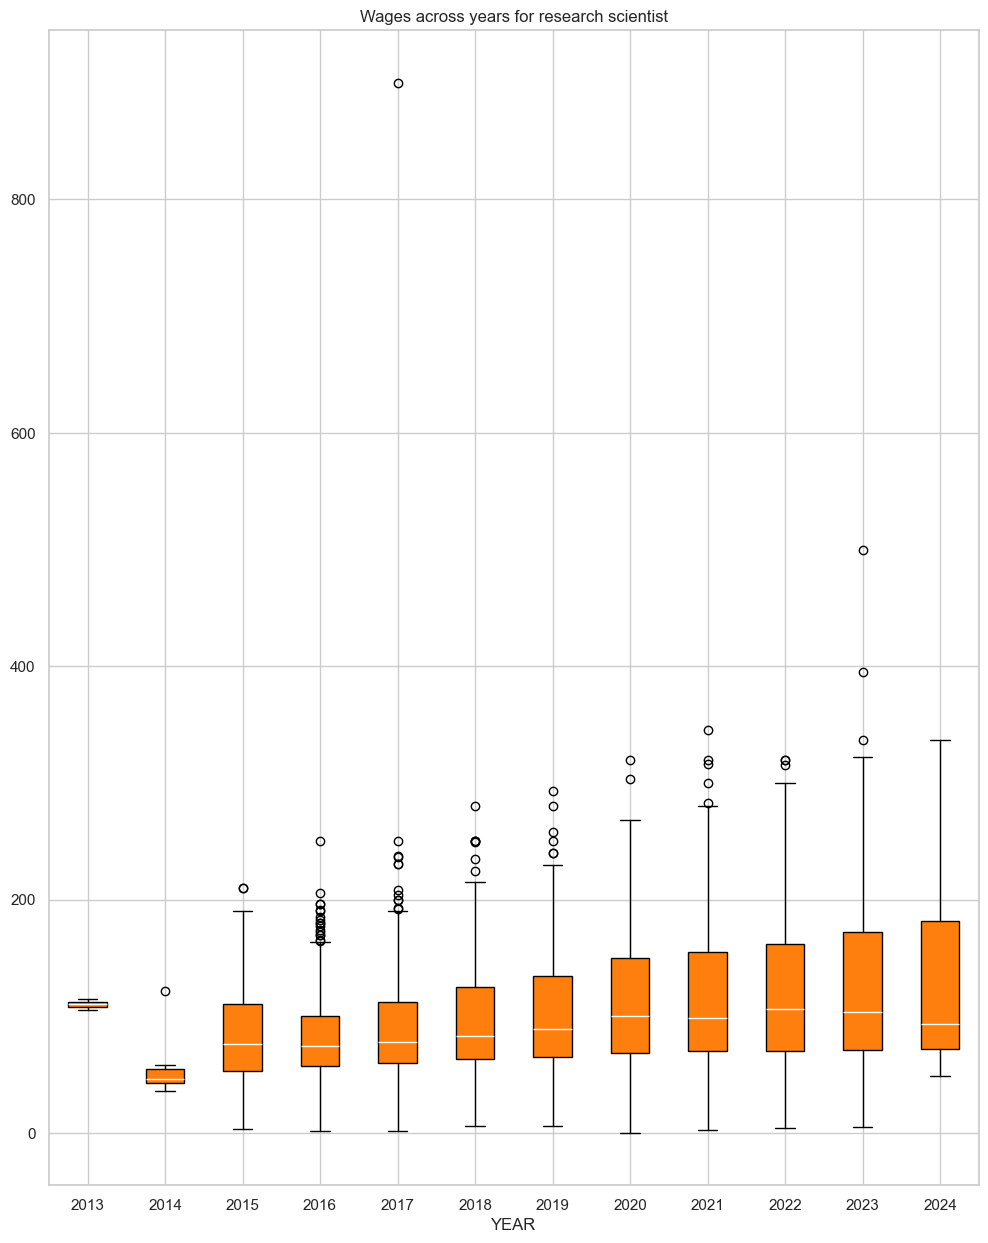

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/2379994539.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,


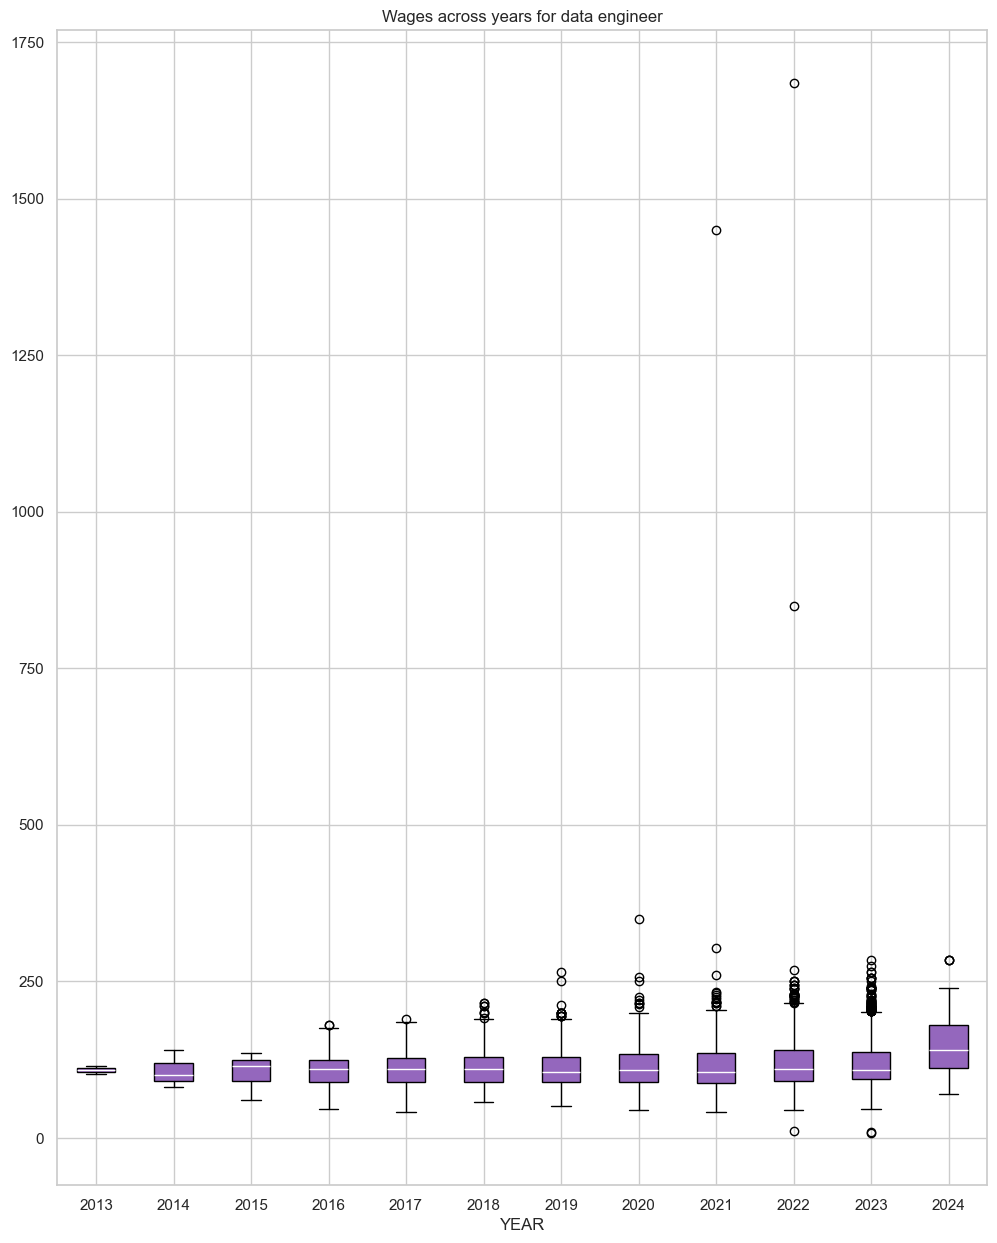

In [156]:
colors = ['#2ca02c','#1f77b4','#d62728','#ff7f0e','#9467bd']
for job_function, color in zip(df_plt['TYPE'].unique(), colors):
    df_filtered = df_plt[df_plt['TYPE'] == job_function]
    df_year = df_filtered.groupby('YEAR')['y'].apply(list)

    fig, ax = plt.subplots(figsize=(12, 15))
    box = ax.boxplot(df_year.values, labels=df_year.index.map(str), patch_artist=True,
                     boxprops=dict(facecolor=color),
                     medianprops=dict(color='white'))
    ax.set_title(f'Wages across years for {job_function}')
    ax.set_xlabel('YEAR')
#    ax.set_ylabel('y')
    plt.show()

For data scientists, median wages have decreased significantly since 2014 and have increased minimally since. The distribution of wages have also widened, with the wage discrepancy between the 75th and 25th percentile is the largest this year.


For data analysts, median wages have fluctuated minimally across years, except for a sudden increase in 2024. While the distribution of wages widened significantly in 2024, the lowest wage has also increased significantly compared to 2023.

For others, both the median wage and the wage distribution have generally increased over the years.

For research scientists, while median wage has fluctuated, the wage distribution has significantly widened over the years, and with positive wage outliers generally outearning more than 1.5x of the median wage. Currently in 2024, the median wage skews negative of the general wage distribution. 

For data engineers, the median wage has fluctuated over the years, and wage distribution has also increased minimally. 2024 saw the largest increase in median wage.

### State

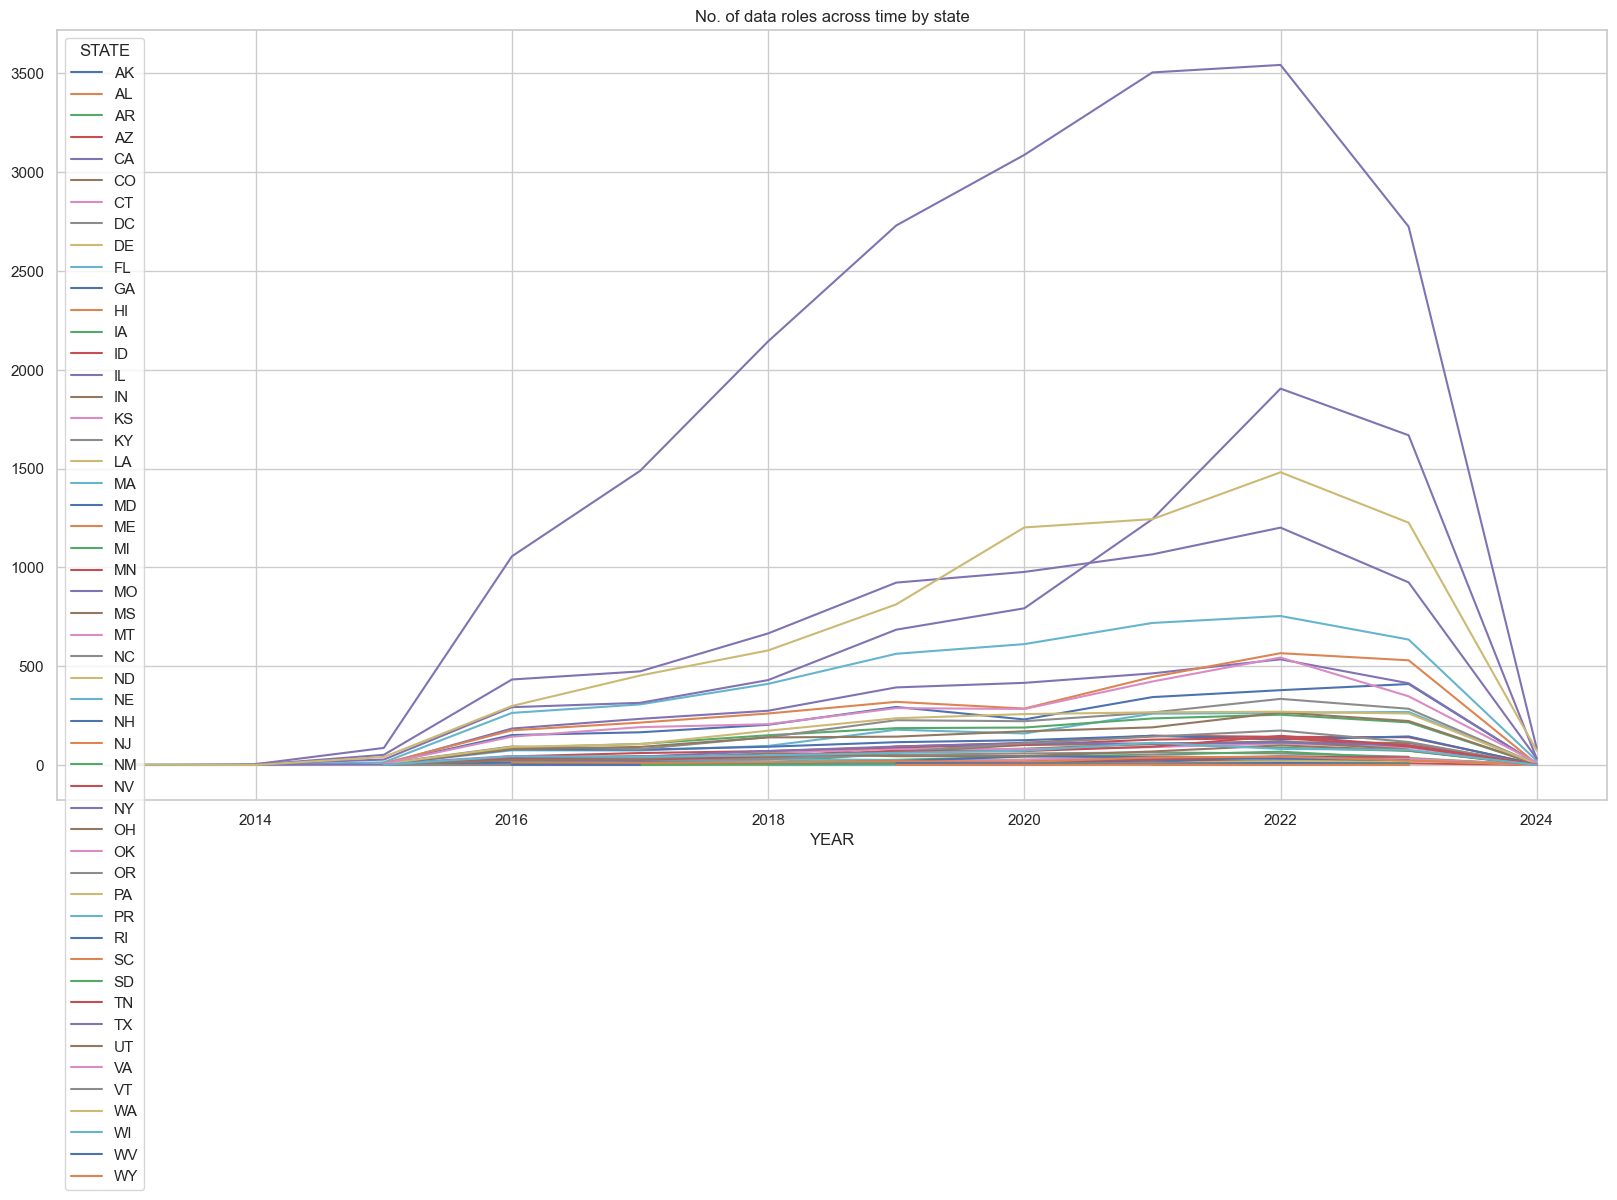

In [157]:
category = "STATE"

df_plt = all_df2[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
ax = df_plt.plot.line(figsize=(20, 10), title="No. of data roles across time by state")

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/445677225.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_state_agg['STATE_AGG'].mask(((df_state_agg["YEAR"] == year) & (df_state_agg["STATE"].isin(all_S))),'S', inplace=True)
/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/445677225.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never 

STATE_AGG
S    39492
L    35318
Name: count, dtype: int64


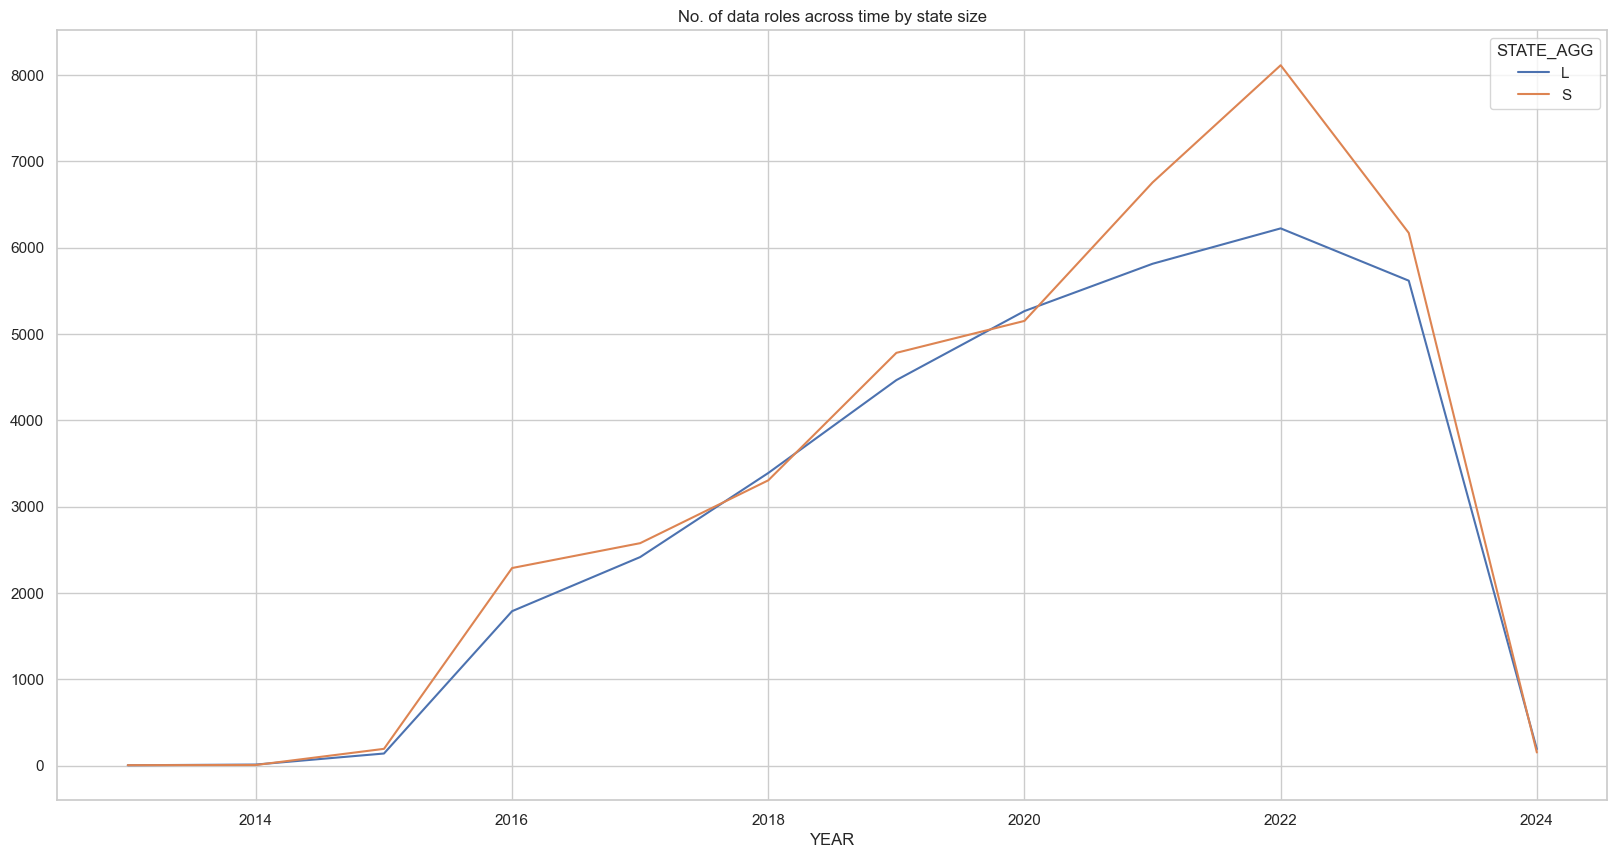

In [158]:
category = "STATE"

years = all_df2["YEAR"].unique()
df_state_agg = all_df2.copy()
df_state_agg["STATE_AGG"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_state_agg[df_state_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.95)
    all_S = list(df_temp[df_temp["size"] < median]["STATE"])
    df_state_agg['STATE_AGG'].mask(((df_state_agg["YEAR"] == year) & (df_state_agg["STATE"].isin(all_S))),'S', inplace=True)

category = "STATE_AGG"

df_plt = df_state_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_state_agg["STATE_AGG"].value_counts())
ax = df_plt.plot.line(figsize=(20, 10), title="No. of data roles across time by state size")

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/4007058756.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plt = df_state_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])


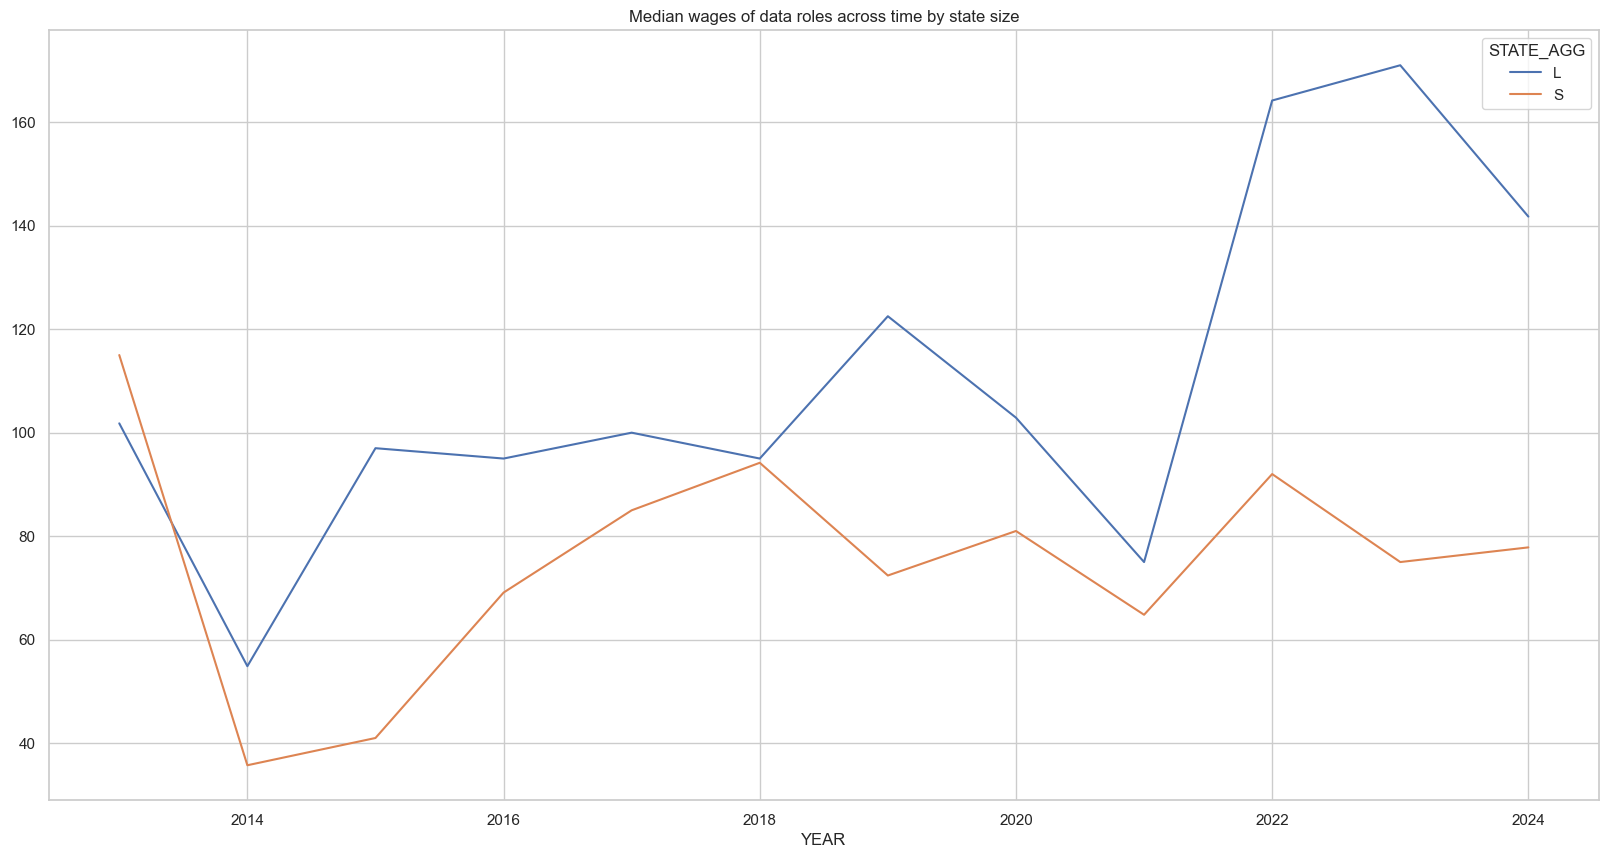

In [159]:
# get median wage of each state size for each year
df_plt = df_state_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.line(figsize=(20, 10), title="Median wages of data roles across time by state size")

### Employer

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/3063944648.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_employer_agg['EMPLOYER_AGG'].mask(((df_employer_agg["YEAR"] == year) & (df_employer_agg["EMPLOYER"].isin(all_S))),'S', inplace=True)
/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/3063944648.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace m

EMPLOYER_AGG
L    38824
S    35986
Name: count, dtype: int64


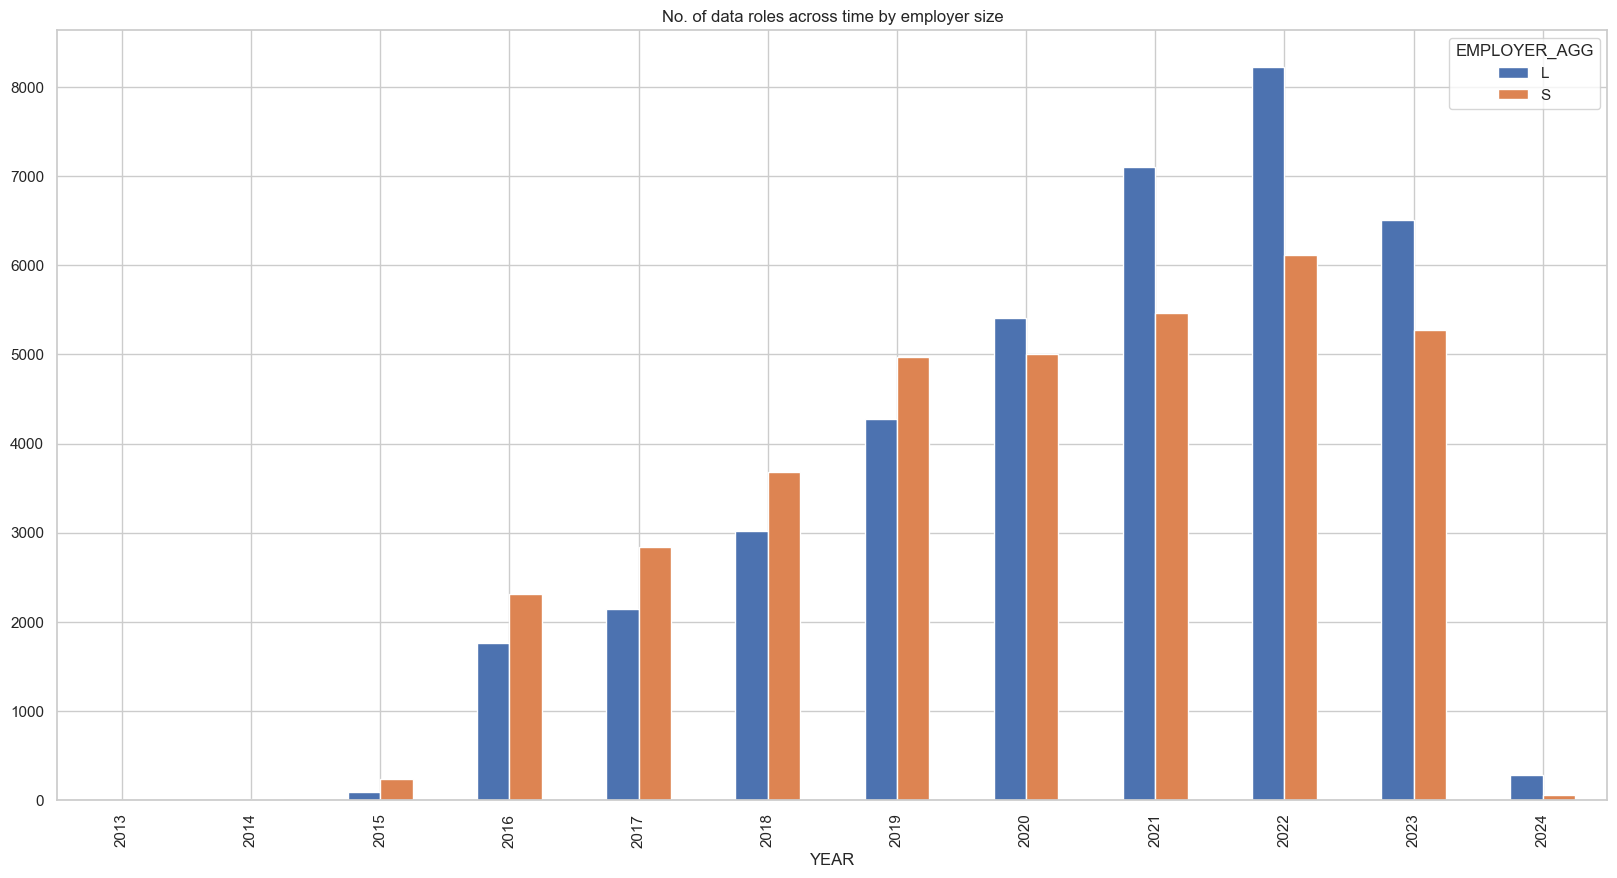

In [160]:
category = "EMPLOYER"

years = all_df2["YEAR"].unique()
df_employer_agg = all_df2.copy()
df_employer_agg["EMPLOYER_AGG"] = "L"

# get cumulative no. of hires each year
for year in years:
    df_temp = df_employer_agg[df_employer_agg["YEAR"] <= year].copy()
    df_temp = df_temp[[category, "y"]].groupby([category], as_index = False).size()
    median = np.quantile(df_temp["size"], 0.95)
    all_S = list(df_temp[df_temp["size"] < median]["EMPLOYER"])
    df_employer_agg['EMPLOYER_AGG'].mask(((df_employer_agg["YEAR"] == year) & (df_employer_agg["EMPLOYER"].isin(all_S))),'S', inplace=True)

category = "EMPLOYER_AGG"

df_plt = df_employer_agg[["YEAR", category]].groupby(["YEAR", category], as_index = False).size().copy()
df_plt = df_plt.pivot(index='YEAR', columns=category, values='size')
print(df_employer_agg["EMPLOYER_AGG"].value_counts())
ax = df_plt.plot.bar(figsize=(20, 10), title="No. of data roles across time by employer size")

/var/folders/pj/sdqds5z50pn0bs_c57lvlfzr0000gn/T/ipykernel_17554/541045626.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plt = df_employer_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])


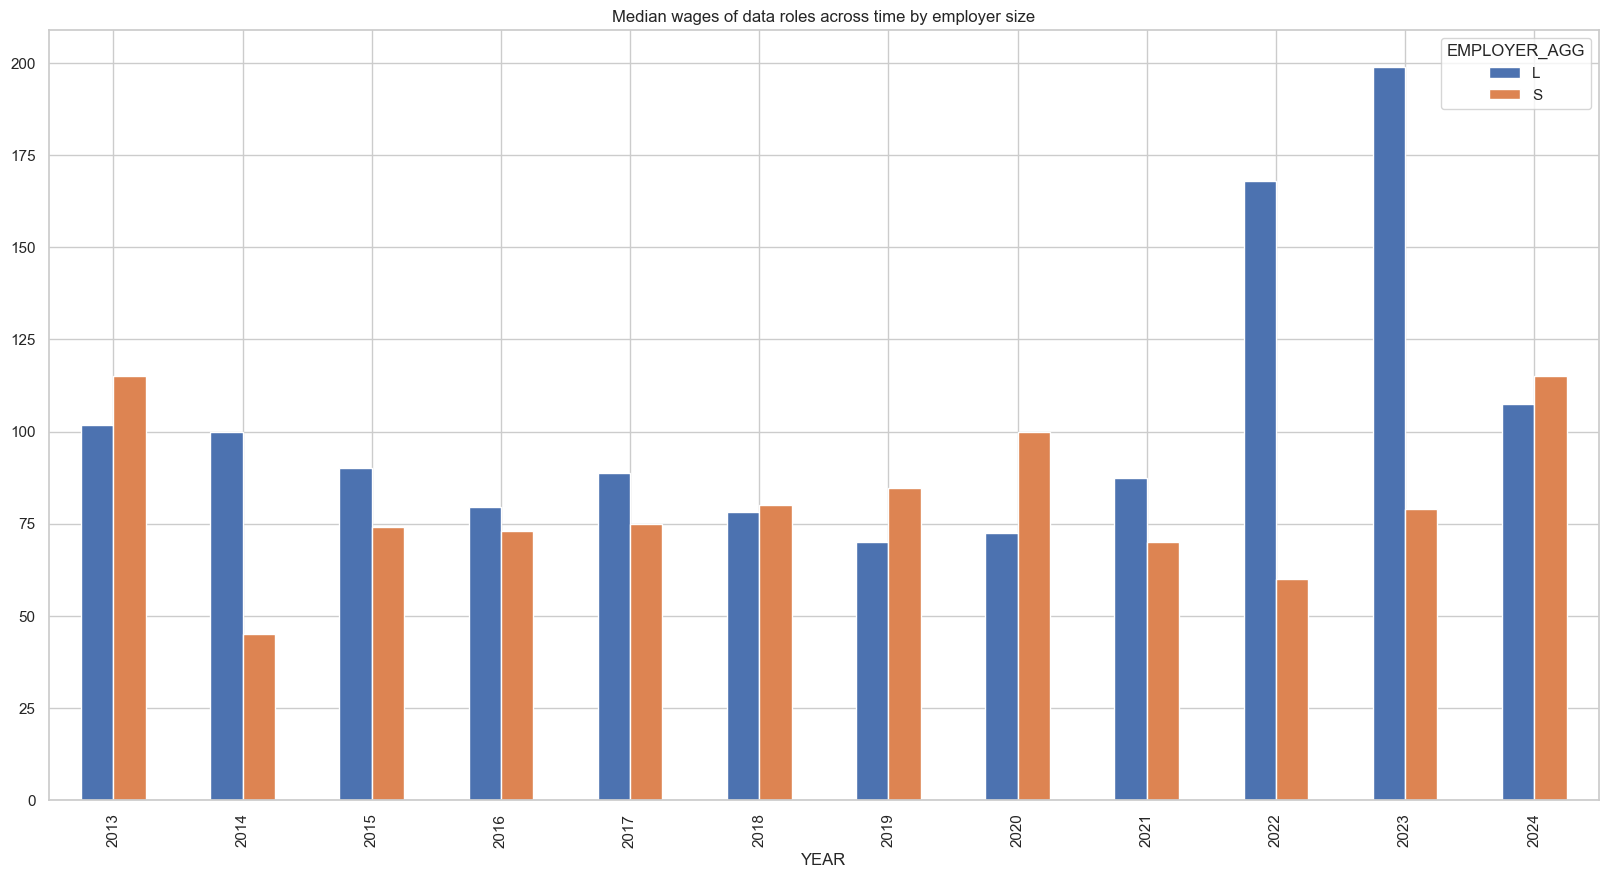

In [161]:
# get median wage of each job role for each year
df_plt = df_employer_agg[["YEAR", category, "y"]].groupby(["YEAR", category], as_index = False).apply(lambda x:x.iloc[len(x)//2])
df_plt = df_plt.pivot(index='YEAR', columns=category, values='y')
ax = df_plt.plot.bar(figsize=(20, 10), title="Median wages of data roles across time by employer size")

### Putting them all together

In [162]:
df_cleaned = df_type_agg.copy()
df_cleaned["STATE"] = df_state_agg["STATE_AGG"]
df_cleaned["EMPLOYER"] = df_employer_agg["EMPLOYER_AGG"]
df_cleaned.sample(5)

,EMPLOYER,JOB TITLE,y,LOCATION,SUBMIT DATE,START DATE,TYPE,YEAR,STATE
18508,L,DATA SCIENTIST ADVISOR,86.029,"COLLIERVILLE, TN",2020-05-29,2020-10-01,data scientist,2020,S
9260,L,DATA SCIENTIST,115.000,"SAN FRANCISCO, CA",2018-09-07,2019-02-16,data scientist,2019,L
13031,S,DATA SCIENTIST,137.885,"NEW YORK, NY",2016-03-04,2016-09-01,data scientist,2016,L
11987,S,DATA SCIENTIST,130.000,"BOSTON, MA",2018-04-20,2018-04-30,data scientist,2018,S
73859,L,MACHINE LEARNING INFRA OPS ENGINEER,165.000,"PALO ALTO, CA",2021-08-18,2021-09-01,others,2021,L


# Encoding

# Regression